<a href="https://colab.research.google.com/github/Vasyl808/NULP_NLP/blob/main/nlp_word2vec_done.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip text8.zip

Archive:  text8.zip
  inflating: text8                   


Імпортує необхідні модулі та встановлюємо гіперпараметри. Пробував декілька раз тренувати з різними гіперпараметрами, ці проявили себе найкраще.

In [9]:
import re
import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import spacy
from tqdm import tqdm
from typing import Union
import pickle
import warnings

warnings.filterwarnings("ignore")


hyperparameters: dict[str: Union[int, float]] = {
    'CONTEXT_SIZE': 2,
    'NUM_EPOCH': 3,
    'BATCH_SIZE': 1024,
    'EMBEDDING_DIMENSION': 100,
    'LEARNING_RATE': 0.01
}

Перепроцесінг тексту (токенізація) та створення тренувальних зразків у фоматі: (['algorithms', 'using', 'intelligence', 'are'], 'artificial'), де artificial є нашим цільовим словом, а 'algorithms', 'using' та 'intelligence', 'are' його лівий та правий контекст відповідно

In [3]:
def tokenize(text: str) -> list[str]:
    return re.findall(r"\b\w+\b", text)


def preprocess(text: str) -> list[str]:
    text = text.lower()
    return tokenize(text)


def make_training_examples(tokens: list[str], context_size: int) -> tuple[list[list[str]], list[str]]:
    for i in range(context_size, len(tokens) - context_size):
        left_context = tokens[i - context_size : i]
        target = tokens[i]
        right_context = tokens[i + 1 : i + context_size + 1]
        context = left_context + right_context
        yield context, target

Клас словника для пошуку токенів за інтдексом і навпаки

In [4]:
class Vocabulary:
    def __init__(self, tokens: list[str]) -> None:
        self.vocab = sorted(set(tokens))
        self.token_to_index = {token: i for i, token in enumerate(self.vocab)}
        self.index_to_token = {i: token for i, token in enumerate(self.vocab)}

    def __len__(self) -> int:
        return int(len(self.vocab))

Клас для роботи з набором даних. Векторизує наш контекст та таргет

In [5]:
class WordEmbeddingDataset(Dataset):
    def __init__(self, tokens: list[str], context_size: int, vocab: Vocabulary):
        self.examples = list(make_training_examples(tokens, context_size))
        self.vocab = vocab

    def __len__(self) -> int:
        return int(len(self.examples))

    def __getitem__(self, idx: int) -> tuple[list[int], int]:
        context, target = self.examples[idx]
        context_vector = torch.tensor([self.vocab.token_to_index[token] for token in context], dtype=torch.long)
        target_vector = self.vocab.token_to_index[target]
        return context_vector, target_vector

Сама модель ембедінга. Мість метод для тренування, отримання ембедінгів, пошуку подібних слів до даного на основі косинусної подібності, та зберігання у файл ембедінгів + словника

In [6]:
class EmbeddingModel:
    def __init__(self, vocab: Vocabulary, embed_dim: int):
        self.vocab = vocab
        self.embed_dim = embed_dim
        self.W_in = torch.randn(len(vocab.vocab),
                                embed_dim,
                                requires_grad=True,
                                device='cuda'
                                )
        self.W_out = torch.randn(embed_dim,
                                 len(vocab.vocab),
                                 requires_grad=True,
                                 device='cuda'
                                 )

    def train(self, training_text: str, num_epochs: int, batch_size: int):
        tokens = preprocess(training_text)

        dataset = WordEmbeddingDataset(
            tokens,
            hyperparameters.get('CONTEXT_SIZE'),
            self.vocab
        )

        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        optimizer = torch.optim.Adam(
            [self.W_in, self.W_out],
            lr=hyperparameters.get('LEARNING_RATE')
        )

        for epoch in range(num_epochs):
            epoch_loss = 0
            num_examples = 0

            for context_vector, target_vector in tqdm(dataloader):
                num_examples += context_vector.size(0)
                optimizer.zero_grad()
                hidden = self.W_in[context_vector].sum(dim=1)
                logits = hidden @ self.W_out
                log_probs = torch.log_softmax(logits, dim=1)

                batch_size_actual = target_vector.size(0)
                loss = -log_probs[torch.arange(batch_size_actual), target_vector]
                loss.mean().backward()
                optimizer.step()

                epoch_loss += loss.sum().item()

            epoch_loss /= num_examples
            print(f"Epoch: {epoch + 1}, Loss: {epoch_loss:.4f}")

    def get_embeddings(self):
        return self.W_in + self.W_out.t()

    def get_similar_words(self, word, top_n=10):
        if word not in self.vocab.token_to_index:
            raise ValueError(f"Word '{word}' not found in vocabulary.")

        word_index = self.vocab.token_to_index[word]
        word_embedding = self.get_embeddings()[word_index]

        all_embeddings = torch.tensor(self.get_embeddings(), device='cuda')
        word_embedding = torch.tensor(word_embedding, device='cuda')

        # Нормалізація векторів
        all_embeddings = all_embeddings / torch.norm(all_embeddings, dim=1, keepdim=True)
        word_embedding = word_embedding / torch.norm(word_embedding)

        # Обчислюємо косинусну подібність
        similarities = torch.matmul(all_embeddings, word_embedding)

        # Виключаємо вхідне слово
        similarities[word_index] = -1.0

        # Знаходимо найближчі слова
        top_indices = torch.topk(similarities, top_n).indices.cpu().numpy()

        return [(self.vocab.index_to_token[idx], similarities[idx].item()) for idx in top_indices]

    def save_embeddings(self, filepath: str):
        torch.save({
            'W_in': self.W_in.detach().cpu(),
            'W_out': self.W_out.detach().cpu()
        }, filepath)
        print(f"Embeddings saved to {filepath}")

    def save_vocab(self, filepath: str):
        with open(filepath, 'wb') as f:
            pickle.dump(self.vocab, f)
        print(f"Vocabulary saved to {filepath}")




In [ ]:
with open('/content/text8', 'r') as file:
        training_text = file.read()

vocab = Vocabulary(preprocess(training_text))

len(vocab)

253854

Тренував ембедінги на text8.

In [ ]:
model = EmbeddingModel(
    vocab,
    hyperparameters.get('EMBEDDING_DIMENSION')
)

model.train(
    training_text,
    hyperparameters.get('NUM_EPOCH'),
    hyperparameters.get('BATCH_SIZE')
)

100%|██████████| 16607/16607 [32:19<00:00,  8.56it/s]


Epoch: 1, Loss: 9.2087


100%|██████████| 16607/16607 [32:42<00:00,  8.46it/s]


Epoch: 2, Loss: 6.4924


100%|██████████| 16607/16607 [32:40<00:00,  8.47it/s]


Epoch: 3, Loss: 6.3382


In [ ]:
model.save_embeddings('embeddings.pt')
model.save_vocab('vocab.pkl')

Embeddings saved to embeddings.pt
Vocabulary saved to vocab.pkl


In [7]:
def load_embeddings(filepath: str):
    data = torch.load(filepath)
    W_in = data['W_in']
    W_out = data['W_out']
    return W_in, W_out


def load_vocab(filepath: str):
    with open(filepath, 'rb') as f:
        vocab = pickle.load(f)
    return vocab

Перевірив властивість розміщувати поруч подібні слова

In [10]:
W_in, W_out = load_embeddings('/content/drive/MyDrive/embedding/embeddings.pt')
vocab = load_vocab('/content/drive/MyDrive/embedding/vocab.pkl')

model = EmbeddingModel(vocab, hyperparameters.get('EMBEDDING_DIMENSION'))
model.W_in = W_in
model.W_out = W_out

word_to_search = 'water'
similar_words = model.get_similar_words(word_to_search)
print(f"Words similar to '{word_to_search}': {similar_words}")

Words similar to 'water': [('gas', 0.5928983688354492), ('fresh', 0.561077356338501), ('oil', 0.5599737167358398), ('fuel', 0.5570586323738098), ('supply', 0.5483889579772949), ('heating', 0.5444967746734619), ('air', 0.5434978604316711), ('food', 0.5355669856071472), ('liquid', 0.532396137714386), ('total', 0.5302374958992004)]


In [11]:
model.get_embeddings()[vocab.token_to_index['water']]

tensor([ 0.1777, -0.3501, -0.7134,  0.1764, -0.0941, -0.1261,  0.0547,  0.1756,
         0.0601,  0.2111,  1.0422, -0.5202,  0.0277, -0.6202,  0.1606, -0.1621,
         0.5752, -0.3417, -0.0825, -0.2935, -0.3850,  1.4978, -0.3992, -0.0946,
         0.4289, -0.0667,  0.3965, -0.6062,  0.3715, -0.0839,  0.4783,  0.6844,
        -0.1448, -0.2403,  0.0789,  0.2453, -1.3663, -0.3426,  0.3818, -0.2449,
        -0.1816,  0.2226,  0.2619, -0.2593, -0.4053,  0.7370,  0.0767, -0.1849,
         0.2872, -0.3541, -0.0271,  0.1961,  0.3929,  0.2227,  0.0952,  0.4372,
        -0.3768,  0.6678,  0.8301, -0.3270, -0.6569,  0.9702, -0.1212, -0.3728,
         0.3799,  0.1586,  0.1836,  0.1756,  0.1843, -0.1493, -0.3772, -0.4256,
        -0.1510,  0.1812,  0.1328, -1.1263,  0.2871,  0.4222, -0.3837, -0.1121,
        -0.2006,  0.7123,  1.0305,  0.1256, -0.2584, -0.2696,  0.5041,  0.2392,
        -0.0948,  0.1025, -0.2275, -0.1467,  0.5501, -1.0511,  0.4141,  0.1327,
         0.2886, -0.6817, -0.0589, -0.19

In [12]:
word_to_search = 'word'
similar_words = model.get_similar_words(word_to_search)
print(f"Words similar to '{word_to_search}': {similar_words}")

Words similar to 'word': [('meaning', 0.6530529856681824), ('term', 0.6371171474456787), ('greek', 0.5927851796150208), ('phrase', 0.5592740774154663), ('latin', 0.5560826659202576), ('language', 0.5532324910163879), ('name', 0.5413400530815125), ('hebrew', 0.5272836685180664), ('modern', 0.5052066445350647), ('terminology', 0.5028757452964783)]


In [57]:
word_to_search = 'london'
similar_words = model.get_similar_words(word_to_search)
print(f"Words similar to '{word_to_search}': {similar_words}")

Words similar to 'london': [('city', 0.6735579967498779), ('berlin', 0.6071721315383911), ('york', 0.5824779868125916), ('manchester', 0.5443627834320068), ('amsterdam', 0.5342712998390198), ('new', 0.5340930223464966), ('east', 0.520696759223938), ('walford', 0.5161587595939636), ('chicago', 0.5141729116439819), ('centre', 0.5080441236495972)]


Перевірив векторну арифметику і воно працює)

In [53]:
embeddings = model.get_embeddings()

In [54]:
def find_similar_words(embeddings, vocab, input_vector, top_k=10):
    normalized_embeddings = F.normalize(embeddings, p=2, dim=1)
    normalized_input_vector = F.normalize(input_vector.unsqueeze(0), p=2, dim=1)

    cosine_similarities = torch.matmul(normalized_embeddings, normalized_input_vector.T).squeeze()

    top_k_indices = torch.topk(cosine_similarities, top_k).indices
    most_similar_words = [vocab.index_to_token[idx.item()] for idx in top_k_indices]

    return most_similar_words

In [56]:
v1 = embeddings[vocab.token_to_index['london']]
v2 = embeddings[vocab.token_to_index['england']]
v3 = embeddings[vocab.token_to_index['germany']]

result_vector = v1 - v2 + v3

similar_words = find_similar_words(embeddings, vocab, result_vector, top_k=10)
print(f"The top {len(similar_words)} most similar words are: {similar_words}")

The top 10 most similar words are: ['berlin', 'london', 'germany', 'dresden', 'cologne', 'hamburg', 'central', 'china', 'beijing', 'prague']


Застосував для задачі класифікації

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import fetch_20newsgroups
import numpy as np


categories = ['talk.politics.guns', 'soc.religion.christian']
newsgroups = fetch_20newsgroups(subset='all', categories=categories)

train_texts, test_texts, train_labels, test_labels = train_test_split(newsgroups.data[:200], newsgroups.target[:200], test_size=0.2, random_state=42)

all_tokens = [token for text in train_texts for token in preprocess(text)]
vocab = Vocabulary(all_tokens)


In [ ]:
# 1 - talk.politics.guns
# 0 - soc.religion.christian

In [ ]:
test_texts[0]

'From: dnewcomb@whale.st.usm.edu (Donald R. Newcomb)\nSubject: Re: Some more about gun control...\nNntp-Posting-Host: whale.st.usm.edu\nOrganization: University of Southern Mississippi\nLines: 145\n\nFirst, I would like to say how much I appreciate having so literate and\nerudite an individual as Mr. Rutledge with whom to discuss this topic.\nFrankly, most anti-RKBA posters refuse even to approach the topic of\nthe original understanding of the Bill of Rights as detailed in the\nwritings of the era. This  is most refreshing.\n\nSecond, I must apologize for leaving the discussion for several days.\nMy brigade\'s quarterly drill was this weekend and I needed to attend\nto several matters pertaining to the State Militia.\n\nSome people seem to feel that the concept of the Militia is an anachro-\nnism that is out of place in the 20th century. I\'m not sure the Swiss\nwould agree and I think perhaps a discussion of how the Militia, both\norganized and unorganized, fits into the defense plan

In [ ]:
test_labels[0]

1

In [ ]:
np.sum(train_labels == 0)

92

In [ ]:
np.sum(train_labels == 1)

68

In [ ]:
np.sum(test_labels == 0)

21

In [ ]:
np.sum(test_labels == 1)

19

Функції для ембедінгу тексту

In [ ]:
def get_word_embedding(word, model, vocab):
    if word in vocab.token_to_index:
        return model.get_embeddings()[vocab.token_to_index[word]]

    return torch.zeros(model.embed_dim).to('cuda')


def encode_text(text, model, vocab, max_len=24):
    tokens = preprocess(text)

    embeddings = [get_word_embedding(token, model, vocab) for token in tokens[:max_len]]
    embeddings = [emb.to('cuda') for emb in embeddings]

    embeddings += [torch.zeros(model.embed_dim).to('cuda')] * (max_len - len(embeddings))  # Padding

    return torch.stack(embeddings)

Проста модель LSTM для класифікації

In [ ]:
import torch.nn as nn


class TextClassifier(nn.Module):
    def __init__(self, embed_dim, hidden_dim, output_dim):
        super(TextClassifier, self).__init__()
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        _, (hidden, _) = self.lstm(x)
        out = self.fc(hidden[-1])
        return out


hidden_dim = 64
output_dim = 2

model_classifier = TextClassifier(hyperparameters['EMBEDDING_DIMENSION'], hidden_dim, output_dim).to('cuda')
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_classifier.parameters(), lr=0.01)

In [ ]:
from torch.utils.data import TensorDataset, DataLoader


train_embeddings = torch.stack([encode_text(text, model, vocab) for text in train_texts])
test_embeddings = torch.stack([encode_text(text, model, vocab) for text in test_texts])



Створив даталоадери

In [ ]:
train_labels = torch.tensor(train_labels).to('cuda')
test_labels = torch.tensor(test_labels).to('cuda')

train_data = TensorDataset(train_embeddings, train_labels)
test_data = TensorDataset(test_embeddings, test_labels)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

Трейн луп

In [ ]:
for epoch in range(10):
    model_classifier.train()
    epoch_loss = 0
    for texts, labels in train_loader:
        optimizer.zero_grad()
        outputs = model_classifier(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(train_loader)}')

Epoch 1, Loss: 0.7080628871917725
Epoch 2, Loss: 0.5378948748111725
Epoch 3, Loss: 0.36480011641979215
Epoch 4, Loss: 0.19136251956224443
Epoch 5, Loss: 0.07322391495108604
Epoch 6, Loss: 0.016830880381166934
Epoch 7, Loss: 0.0051129660569131374
Epoch 8, Loss: 0.004269997216761112
Epoch 9, Loss: 0.006158409186173231
Epoch 10, Loss: 0.005454325466416776


In [ ]:
model_classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model_classifier(texts)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy: {100 * correct / total}%')


Accuracy: 75.0%


In [ ]:
from sklearn.metrics import classification_report


all_preds = []
all_labels = []

model_classifier.eval()
with torch.no_grad():
    for texts, labels in test_loader:
        outputs = model_classifier(texts)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

Вивів матрицю невідповідності + інші метрики, загалом як для 3 епох і відносно невеликого корпусу даних вийшло доволі непогано

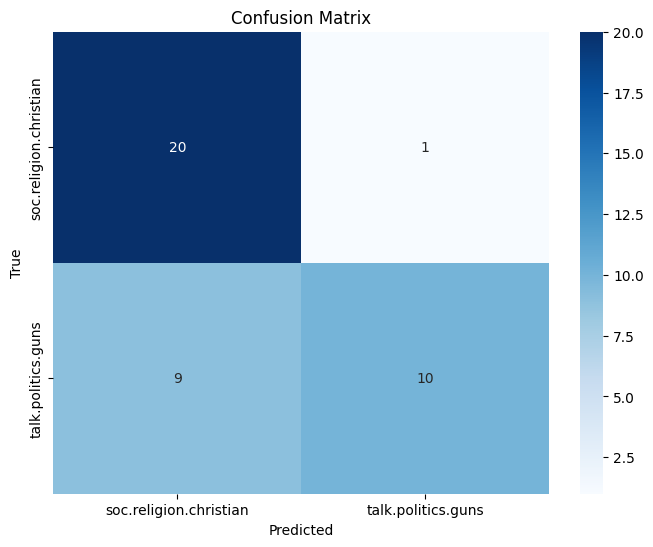

                        precision    recall  f1-score   support

soc.religion.christian       0.69      0.95      0.80        21
    talk.politics.guns       0.91      0.53      0.67        19

              accuracy                           0.75        40
             macro avg       0.80      0.74      0.73        40
          weighted avg       0.79      0.75      0.74        40



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['soc.religion.christian', 'talk.politics.guns'], yticklabels=['soc.religion.christian', 'talk.politics.guns'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(all_labels, all_preds, target_names=['soc.religion.christian', 'talk.politics.guns']))


Лінк на ембедінги: https://drive.google.com/file/d/1QjOLE6ux7l2GnpplN0tOua8Dm9wzaIfd/view?usp=sharing

Лінк на словник: https://drive.google.com/file/d/1olHPfLKM7NjRpY3hmw0_jFDmHxVU7EQQ/view?usp=sharing